# Data Analysis for OH<sup>-</sup>(H<sub>2</sub>O)<sub>4</sub> DMC Data

### Install necessary libraries and define constants

In [2]:
import numpy as np
import pyvibdmc as pv
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib
import pandas as pd
from nn_dmc import *

import h5py

au_to_cm = 219474.63136320

au_to_ang = 0.529177249

h9o5_atoms = np.array([8,1,1,8,1,1,8,1,1,8,1,1,8,1])
h9o5_groups = [[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13]]
h9o5_atom_names = ['O','H','H','O','H','H','O','H','H','O','H','H','O','H']

ml_path = 'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/Machine Learning'
data_path = 'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H9O5-/Data'

In [3]:
energy_shift_old = -83718631.70213751
energy_shift = -381.4501698*au_to_cm

In [53]:
energy_shift - energy_shift_old

-3.6981475353240967

In [30]:
h9o5_3_1_open_mobml_min = np.array([-0.11485162, -3.55076703,  0.48691383,  0.52796788, -1.82503857,  0.9791605,
  0.52484843, -3.76879996, -1.1886809,   5.73775109,  0.30639294, -1.09280851,
  4.1532766,   0.68381593, -0.13314964,  6.03226187, -1.43736706, -0.7309104,
 -2.35311048,  3.54021198, -0.14980174, -0.82627598,  2.6114122,   0.52738475,
 -1.81974748,  4.11243421, -1.77647407, -5.01573625, -1.22916528, -0.61022889,
   -3.5486947,  -2.23163926, -0.17981199, -4.37463781,  0.48527011, -0.4952202,
  1.49837949,  0.97855493,  1.41275234,  1.86053808,  1.32409213,  3.1478365 ]).reshape(14,3)

In [31]:
h9o5_3_1_open_mobml_min

array([[-0.11485162, -3.55076703,  0.48691383],
       [ 0.52796788, -1.82503857,  0.9791605 ],
       [ 0.52484843, -3.76879996, -1.1886809 ],
       [ 5.73775109,  0.30639294, -1.09280851],
       [ 4.1532766 ,  0.68381593, -0.13314964],
       [ 6.03226187, -1.43736706, -0.7309104 ],
       [-2.35311048,  3.54021198, -0.14980174],
       [-0.82627598,  2.6114122 ,  0.52738475],
       [-1.81974748,  4.11243421, -1.77647407],
       [-5.01573625, -1.22916528, -0.61022889],
       [-3.5486947 , -2.23163926, -0.17981199],
       [-4.37463781,  0.48527011, -0.4952202 ],
       [ 1.49837949,  0.97855493,  1.41275234],
       [ 1.86053808,  1.32409213,  3.1478365 ]])

In [32]:
save_xyz_file(f"{ml_path}/h9o5/geometries/h9o5_3_1_open_mobml_opt.xyz",h9o5_atom_names,h9o5_3_1_open_mobml_min*au_to_ang)

In [66]:
read_xyz_file(f"{ml_path}/h9o5/geometries/h9o5_3_1_open_mobml_opt_new.xyz")

array([[-0.11485162, -3.55076703,  0.48691383],
       [ 0.52796788, -1.82503857,  0.9791605 ],
       [ 0.52484843, -3.76879996, -1.1886809 ],
       [ 5.73775109,  0.30639294, -1.09280851],
       [ 4.1532766 ,  0.68381593, -0.13314964],
       [ 6.03226187, -1.43736706, -0.7309104 ],
       [-2.35311048,  3.54021198, -0.14980174],
       [-0.82627598,  2.6114122 ,  0.52738475],
       [-1.81974748,  4.11243421, -1.77647407],
       [-5.01573625, -1.22916528, -0.61022889],
       [-3.5486947 , -2.23163926, -0.17981199],
       [-4.37463781,  0.48527011, -0.4952202 ],
       [ 1.49837949,  0.97855493,  1.41275234],
       [ 1.86053808,  1.32409213,  3.1478365 ]])

In [23]:
# Load in excel sheet where I'm keeping track of energy calculations

file_path = f'{ml_path}/h9o5/h9o5_relative_energies.xlsx' # Or the full path
df = pd.read_excel(file_path)
print(df.head())

      Isomer  MOB-ML  MP2 DZ Energy  MP2 DZ tight  MP2 TZ Energy  \
0         C4     NaN    -380.817482   -380.817482    -381.154690   
1        3+1     NaN    -380.817489   -380.817490    -381.155367   
2  3+1 trans     NaN            NaN   -380.816588    -381.154448   

   MP2 TZ//CCSD(T) Energy  MP2 QZ Energy  MP2 QZ//CCSD(T) Energy  \
0             -381.217170    -381.267875             -381.321699   
1             -381.217415    -381.268567             -381.321940   
2             -381.216511    -381.267669             -381.321062   

   MP2 QZ//MOB-ML Energy  MOB-ML New Opt  EGNN unguided ZPE  \
0            -381.449977     -381.450170              23626   
1            -381.449281     -381.449466              23795   
2            -381.448563     -381.448744              23932   

   EGNN unguided error  EGNN guided ZPE  EGNN guided error  
0                   32              NaN                NaN  
1                   34              NaN                NaN  
2                 

In [24]:
rel_mp2_ccsdt_qz = (list(df['MP2 QZ//CCSD(T) Energy']) - df['MP2 QZ//CCSD(T) Energy'][0])*au_to_cm
rel_mp2_qz = (list(df['MP2 QZ Energy']) - df['MP2 QZ Energy'][0])*au_to_cm
rel_mp2_qz_mobml = (list(df['MP2 QZ//MOB-ML Energy']) - df['MP2 QZ//MOB-ML Energy'][0])*au_to_cm
rel_mobml_opt = (list(df['MOB-ML New Opt']) - df['MOB-ML New Opt'][0])*au_to_cm
rel_egnn_ung_zpe = (list(df['EGNN unguided ZPE']) - df['EGNN unguided ZPE'][0])
rel_egnn_ung_error = (list(df['EGNN unguided error']) - df['EGNN unguided error'][0])

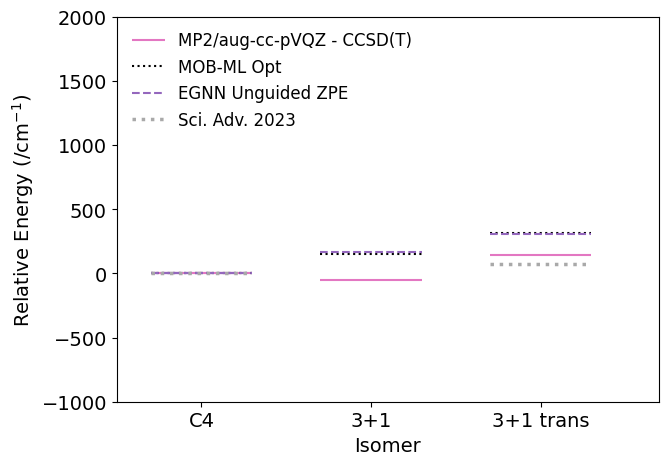

In [27]:
# Plot relative energies of all isomers

plt.rcParams["figure.figsize"] = [7, 5]

# for i, energy in enumerate(rel_mp2_qz):
#     plt.hlines(energy, 5*(i), 5*(i)+3)
# plt.hlines(0, 0, 3, label='MP2/aug-cc-pVQZ')

for i, energy in enumerate(rel_mp2_ccsdt_qz):
    plt.hlines(energy, 5*(i), 5*(i)+3, color = 'tab:pink')
plt.hlines(0, 0, 3, label='MP2/aug-cc-pVQZ - CCSD(T)', color = 'tab:pink')

# for i, energy in enumerate(rel_mp2_qz_mobml):
#     plt.hlines(energy, 5*(i), 5*(i)+3, color='tab:green', linestyle='dashed')
# plt.hlines(0, 0, 3, label='MP2/aug-cc-pVQZ - MOB-ML', color='tab:green', linestyle='dashed')

for i, energy in enumerate(rel_mobml_opt):
    plt.hlines(energy, 5*(i), 5*(i)+3, color='black', linestyle='dotted')
plt.hlines(0, 0, 3, label='MOB-ML Opt', color='black', linestyle='dotted')

for i, energy in enumerate(rel_egnn_ung_zpe):
    plt.hlines(energy, 5*(i), 5*(i)+3, color='tab:purple', linestyle='dashed')
plt.hlines(0, 0, 3, label='EGNN Unguided ZPE', color='tab:purple', linestyle='dashed')

plt.hlines(0.22*350, 10, 13, label='Sci. Adv. 2023', color='darkgray', linestyle='dotted', linewidth=2.5)
plt.hlines(0, 0, 3, color='darkgray', linestyle='dotted', linewidth=2.5)

# for i, energy in enumerate(rel_egnn_ung_zpe):
#     plt.hlines(energy, 5*(i), 5*(i)+3, color='tab:purple', linestyle='dashed')
# plt.hlines(0, 0, 3, label='EGNN Unguided ZPE', color='tab:purple', linestyle='dashed')

# for i, energy in enumerate(rel_egnn_g_zpe):
#     plt.hlines(energy, 5*(i), 5*(i)+3, color='tab:red')
# plt.hlines(0, 0, 3, label='EGNN Guided ZPE', color='tab:red')

plt.legend(fontsize=12, frameon=False, loc='upper left')
plt.xlabel('Isomer')
plt.xlim(-1,15)
plt.xticks(np.arange(1.5,11.5+5, 5), list(df['Isomer']))
plt.ylabel(r'Relative Energy (/cm$^{-1}$)')
plt.ylim(-1000,2000)
plt.show()

### Load in training data generated from MOB-ML DMC simulations

In [38]:
isomer = '3_1_open'
sim_type = 'wide'
sim_num = 1

train_energies_list = []
train_cds_list = []

if sim_type == 'min':
    sim = '500w_1000ts_1dt_0_start'
elif sim_type == 'wide':
    sim = 'scaled_O_x02_1000w_1000ts_10dt_0_start'
else:
    print("Not a valid sim type")

print(f'starting {isomer} {sim_type} sim number {sim_num}')

path = f'{data_path}/mobml_pyscf/{isomer}_start/sim_{sim_num}/{sim}'

training_sim = pv.SimInfo(f'{path}/h9o5_1_sim_info.hdf5')

for b in range(1000):
    cds,energies = training_sim.get_training(f'{path}/h9o5_1_training_{b}ts.hdf5',ret_ang=False, ret_cm=True)
    
    train_cds_list.append(cds)
    train_energies_list.append(energies-energy_shift) #record energy relative to 4+1 minimum


starting 3_1_open wide sim number 1


In [39]:
train_energies = np.concatenate(train_energies_list)
train_cds = np.concatenate(train_cds_list)

In [40]:
#check energy range of simulation
print(round(np.min(train_energies)), round(np.max(train_energies)))

926 117608


In [41]:
np.save(f'{ml_path}/h9o5/training_data/h9o5_{isomer}_mobml_{sim_type}_sim_{sim_num}_training_cds.npy',train_cds)
np.save(f'{ml_path}/h9o5/training_data/h9o5_{isomer}_mobml_{sim_type}_sim_{sim_num}_training_energies.npy',train_energies)

In [77]:
# Load in 
sim_type = 'min'
min_cds, min_energies = make_training_set(ml_path,'h9o5',['c4', '3_1', '3_1_trans', '3_1_open'], [sim_type], [[1]])

In [78]:
import random

# Generate list of indices
indices = list(range(len(min_cds)))

# Shuffle the indices randomly
random.shuffle(indices)

split_idx = 125000

# Partition the data
sample_indices = indices[:split_idx]

min_cds_sample = min_cds[sample_indices]
min_energies_sample = min_energies[sample_indices]

In [79]:
# Load in 
sim_type = 'wide'
wide_cds, wide_energies = make_training_set(ml_path,'h9o5',['c4', '3_1', '3_1_trans', '3_1_open'], [sim_type], [[1]])

In [80]:
import random

# Generate list of indices
indices = list(range(len(wide_cds)))

# Shuffle the indices randomly
random.shuffle(indices)

split_idx = 375000

# Partition the data
sample_indices = indices[:split_idx]

wide_cds_sample = wide_cds[sample_indices]
wide_energies_sample = wide_energies[sample_indices]

In [81]:
h9o5_mobml_opt_energy_dict = {'c4': -381.450169781943,
                              '3_1': -381.449466413131,
                              '3_1_trans': -381.448743775464,
                              '3_1_open': -381.448561503989}

In [82]:
isomers = ['c4', '3_1', '3_1_trans', '3_1_open']
min_geoms = []
min_energies = []
for isom in isomers:
    min_geom = read_xyz_file(f'{ml_path}/h9o5/geometries/h9o5_{isom}_mobml_opt_new.xyz')
    min_energy = h9o5_mobml_opt_energy_dict[isom]*au_to_cm - energy_shift
    min_geoms.append(min_geom)
    min_energies.append(min_energy)
min_geoms = np.array(min_geoms)
min_energies = np.array(min_energies)


In [83]:
training_cds = np.concatenate([min_cds_sample, wide_cds_sample, min_geoms])
training_energies = np.concatenate([min_energies_sample, wide_energies_sample, min_energies])

In [84]:
np.save(f'{ml_path}/h9o5/training_data/h9o5_four_isoms_125k_min_375k_wide_cds.npy',training_cds)
np.save(f'{ml_path}/h9o5/training_data/h9o5_four_isoms_125k_min_375k_wide_energies.npy',training_energies)

### Compare energy distributions between the different parts of the training data

In [5]:
def plot_training_data(isomer):

    _, train_min_energies = make_training_set(ml_path, 'h9o5', [isomer], ['min'], [[1]])
    _, train_wide_energies = make_training_set(ml_path, 'h9o5', [isomer], ['wide'], [[1]])
    _, train_reg_energies = make_training_set(ml_path, 'h9o5', [isomer], ['reg'], [[1,2,3,4,5]])
    _, train_test_energies = make_training_set(ml_path, 'h9o5', [isomer], ['test'], [[1]])

    #dmc_energies = np.load(f'{ml_path}/h11o6/training_data/h11o6_{isomer}_dmc_energies.npy')

    n, bins = np.histogram(train_min_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} min')

    n, bins = np.histogram(train_wide_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} wide')

    n, bins = np.histogram(train_reg_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} reg')

    n, bins = np.histogram(train_test_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} test')

    #n, bins = np.histogram(dmc_energies, bins=np.arange(0, 100000, 200), density = True)
    #bin_centers = (bins[:-1] + bins[1:]) / 2
    #plt.plot(bin_centers, n, label = f'{isomer} DMC')

    plt.xlabel(r'MOB-ML Energy (/cm$^{-1}$)')
    plt.ylabel('Density of Points')
    plt.xlim(0, 80000)
    plt.ylim(0, 7e-5)
    plt.legend()
    plt.show()

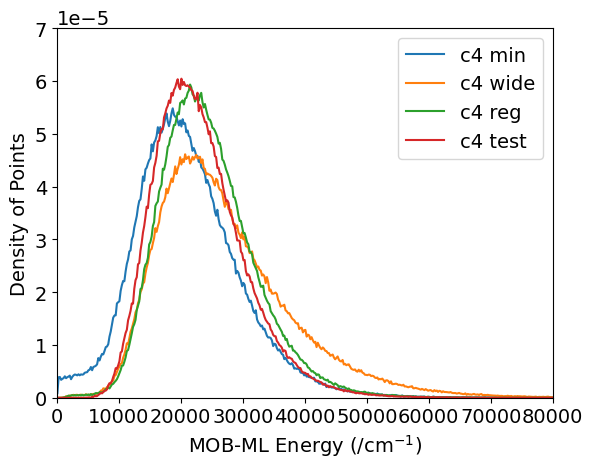

In [6]:
plot_training_data('c4')

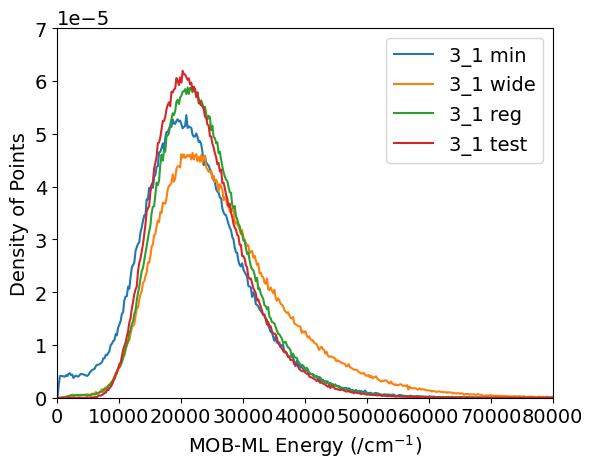

In [27]:
plot_training_data('3_1')

### PCA Analysis of Training Features

In [20]:
def save_pca(data,n_isomers):
    # Load reference structures
    # --------------------------------------------------
    coords = data      # (N_ref, 14, 3)
    oxygen_idx = [0, 3, 6, 9, 12]

    oxygen_coords = coords[:, oxygen_idx, :]  # (N_ref, 5, 3)

    # --------------------------------------------------
    # Build pairwise O–O distance features
    # --------------------------------------------------

    X = np.array([pdist(oxygen_coords[i]) for i in range(len(coords))])

    # --------------------------------------------------
    # Fit scaler, PCA, KMeans
    # --------------------------------------------------
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X_scaled)

    kmeans = KMeans(n_clusters=n_isomers, n_init=50, random_state=0)
    labels = kmeans.fit_predict(X_pca)

    # --------------------------------------------------
    # Save everything
    # --------------------------------------------------
    joblib.dump(scaler, f"{ml_path}/h9o5/scaler.joblib")
    joblib.dump(pca, f"{ml_path}/h9o5/pca.joblib")
    joblib.dump(kmeans, f"{ml_path}/h9o5/kmeans.joblib")

In [23]:
save_pca(min_cds_sample,4)

In [24]:
def plot_pca(data,x_num,y_num,lim,square):
    # --------------------------------------------------
    # Load trained models
    # --------------------------------------------------
    scaler = joblib.load(f"{ml_path}/h9o5/scaler.joblib")
    pca = joblib.load(f"{ml_path}/h9o5/pca.joblib")
    kmeans = joblib.load(f"{ml_path}/h9o5/kmeans.joblib")

    # --------------------------------------------------
    # Load new structures
    # --------------------------------------------------
    coords_new = data # (N_new, 14, 3)
    oxygen_idx = [0, 3, 6, 9, 12]
    oxygen_coords_new = coords_new[:, oxygen_idx, :]

    # --------------------------------------------------
    # Build features
    # --------------------------------------------------
    X_new = np.array([pdist(oxygen_coords_new[i]) for i in range(len(coords_new))])

    # --------------------------------------------------
    # Apply scaler → PCA → KMeans
    # --------------------------------------------------
    X_new_scaled = scaler.transform(X_new)
    X_new_pca = pca.transform(X_new_scaled)
    labels_new = kmeans.predict(X_new_pca)

    isomers = ['c4','3_1_cis','3_1_trans','3_1_open']
    isomer_new_names = [r'C$_4$','3+1 Cis','3+1 Trans', '3+1 Open']

    mobml_min_geoms = []
    for i in isomers:
        geom = read_xyz_file(f"{ml_path}/h9o5/geometries/h9o5_{i}_mobml_opt_new.xyz")
        mobml_min_geoms.append(geom)

    mobml_min_geoms = np.array(mobml_min_geoms)

    min_oxygen_coords = mobml_min_geoms[:, oxygen_idx, :]
    X_min = np.array([pdist(min_oxygen_coords[i]) for i in range(len(min_oxygen_coords))])

    X_min_scaled = scaler.transform(X_min)
    X_min_pca = pca.transform(X_min_scaled)
    labels_min = kmeans.predict(X_min_pca)

    # np.save(f"{ml_path}/h11o6/X_pca_new.npy", X_new_pca)
    # np.save(f"{ml_path}/h11o6/labels_new.npy", labels_new)

    # print("New data projected into reference PCA/KMeans space.")

    # Define the colors you want for each cluster
    cluster_colors = {
        0: "tab:blue",
        1: "tab:purple",
        2: "tab:pink",
        3: "tab:red",
        4: "tab:orange",
        5: "tab:green",
        6: "tab:brown",
        7: "gray",
        8: "black"
    }

    # Map labels to colors
    colors = [cluster_colors[lbl] if lbl in cluster_colors else "gray" for lbl in labels_new]

    plt.figure(figsize=(7,6))
    plt.scatter(X_new_pca[:,x_num-1], X_new_pca[:,y_num-1], c='lightgray', s=6, alpha=0.2)

    for i, name in enumerate(isomers):
        plt.scatter(X_min_pca[i,x_num-1], X_min_pca[i,y_num-1], s=30, alpha=1, label=f'{isomer_new_names[i]}')

    plt.vlines([-square, square],-square,square,color='black')
    plt.hlines([-square,square],-square,square,color='black')

    plt.xlabel(f"PC{x_num}")
    plt.ylabel(f"PC{y_num}")
    plt.legend(frameon=False,fontsize=11)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    #plt.title(f"{sim_type} data in fixed PCA space")
    plt.show()

In [21]:
# Load in 
sim_type = 'min'
reg_cds, reg_energies = make_training_set(ml_path, 'h9o5', ['c4','3_1','3_1_trans', '3_1_open'], [sim_type], [[1]])

In [22]:
import random

# Generate list of indices
indices = list(range(len(reg_cds)))

# Shuffle the indices randomly
random.shuffle(indices)

split_idx = 100000

# Partition the data
test_indices = indices[:split_idx]

min_cds_sample = reg_cds[test_indices]

### Project new set of training data onto saved PCA model from above

In [28]:
# Load in 
sim_type = 'wide'
cds, energies = make_training_set(ml_path, 'h9o5',['c4','3_1','3_1_trans','3_1_open'], [sim_type], [[1]])

In [29]:
import random

# Generate list of indices
indices = list(range(len(cds)))

# Shuffle the indices randomly
random.shuffle(indices)

split_idx = 100000

# Partition the data
test_indices = indices[:split_idx]

wide_cds_sample = cds[test_indices]

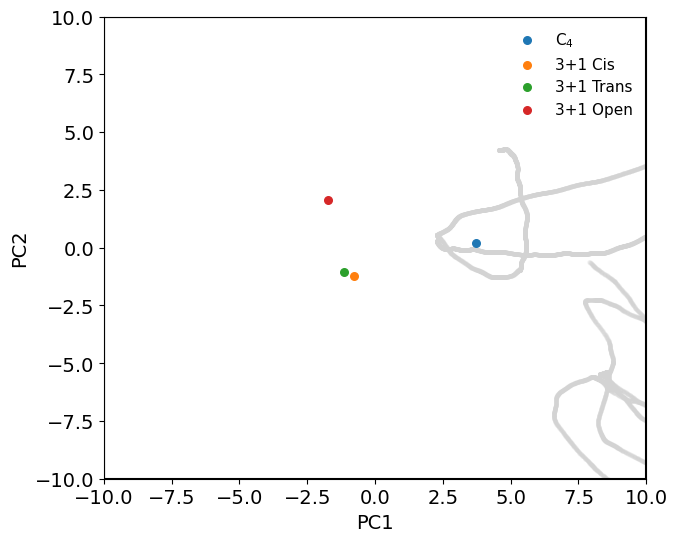

In [70]:
plot_pca(mobml_training,1,2,10,10)

In [8]:
old_energies = np.load(f"{ml_path}/h9o5/training_data_old/h9o5_c4_mobml_test_sim_1_training_energies.npy")

In [9]:
new_energies = old_energies + 3.7
np.save(f"{ml_path}/h9o5/training_data_old/h9o5_c4_mobml_test_sim_1_training_energies_reshifted.npy", new_energies)

In [9]:
isomer = '3_1_open'
mobml_energies = np.load(f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_four_isomers_unguided_50000ts_mobml_energies/final_energies.npy")
energies_shifted = (mobml_energies - -381.4501698)*au_to_cm
np.save(f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_four_isomers_unguided_50000ts_mobml_energies/final_energies_shifted.npy",energies_shifted)

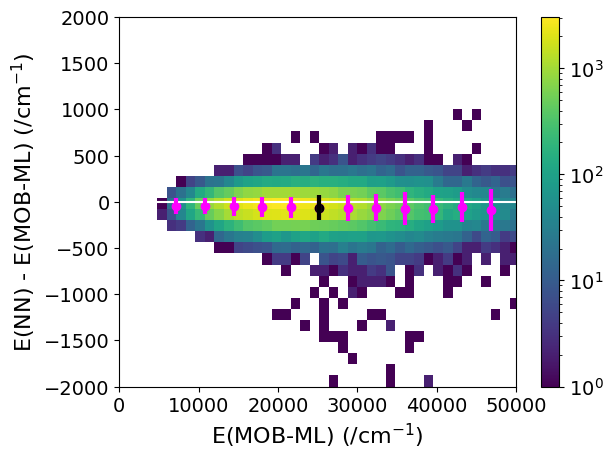

MAE: 77.18, average error: -43.43


In [16]:
isomer = '3_1_open'
model_training = 'four'
plot_egnn_2d_pred_errors('h9o5',
                         f"{ml_path}/h9o5/models/h9o5_egnn_four_64_3_3_ln_best.pth",
                    f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_{model_training}_isomers_unguided_50000ts_cds.npy",
                    f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_{model_training}_isomers_unguided_50000ts_mobml_energies/final_energies_shifted.npy",
                    f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_{model_training}_isomers_unguided_50000ts_dws.npy"
                    )

In [12]:
isomer = '3_1_trans'
dmc_cds = np.load(f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_all_isomers_unguided_50000ts_cds.npy")
dmc_X = molec_atom_sorted_CM(dmc_cds,h9o5_atoms,h9o5_groups,False,True)
np.save(f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_all_isomers_unguided_50000ts_X.npy",dmc_X)

In [13]:
dmc_energies = np.load(f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_all_isomers_unguided_50000ts_mobml_energies/final_energies_shifted.npy")
dmc_y = np.log10(dmc_energies + 100)
np.save(f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_all_isomers_unguided_50000ts_y.npy",dmc_y)

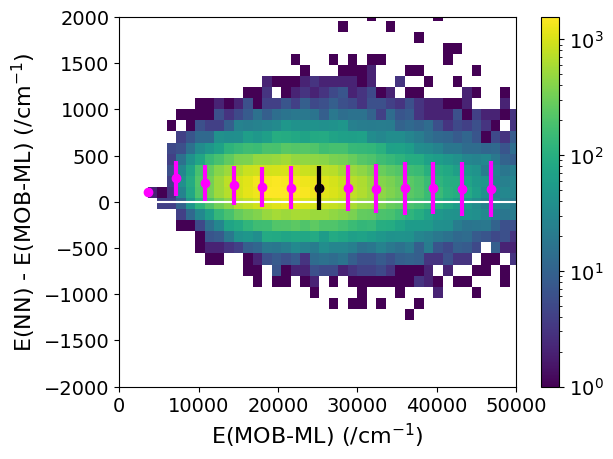

MAE: 223.94, average error: 158.72


In [17]:
isomer = '3_1_trans'
plot_nn_2d_pred_errors('h9o5',
                    f"{ml_path}/h9o5/models/h9o5_3_1_5_reg_NN_model_360hidden_1e-6_decay_molec_atom_sorted_revised_standardized_0.pth",
                    f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_all_isomers_unguided_50000ts_X.npy",
                    f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_all_isomers_unguided_50000ts_y.npy",
                    f"{ml_path}/h9o5/training_sets/h9o5_mobml_full_training_molec_atom_sort_revised_X_3_1_5_reg_means.npy",
                    f"{ml_path}/h9o5/training_sets/h9o5_mobml_full_training_molec_atom_sort_revised_X_3_1_5_reg_stds.npy",
                    #f"{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_all_isomers_unguided_50000ts_dws.npy"
                    )

In [4]:
ZPEs = []

isomer = "3_1_open"
model_type = "EGNN"
model_training = "four" #'four' or 'all'
guided = False

if model_type == "EGNN":
    if guided:
        model = f"{model_training}_isomers/64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/h2o_guided"
    else:
        model = f"{model_training}_isomers/64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/unguided"

elif model_type == "NN":
    if guided:
        model = "450_3hidden_6_decay_molec_atom_sort_standardized/model_5_reg/dist_65_energy_1/h2o_guided"
    else:
        model = "450_3hidden_6_decay_molec_atom_sort_standardized/model_5_reg/dist_65_energy_1/unguided"


walkers = 100000
timesteps = 100000

start_time = 20000
end_time = 100000
step = (end_time - start_time) // 5

tau = np.linspace(0,timesteps,timesteps)
for i in range(1):
    #tutorial_sim = pv.SimInfo('C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data/NN_Data/3_2_start/450_3hidden_6_decay_0_dropout_2mill_revised_molec_atom_sort_standardized/model_5_reg/dist_65_energy_1/h2o_guided/1.0w_100000_walkers_50000t_1dt/H11O6_{2}_sim_info.hdf5'.format(walkers,timesteps,i))
    tutorial_sim = pv.SimInfo(f'{data_path}/{model_type}_Data/{isomer}_start/{model}/1.0w_{walkers}_walkers_{timesteps}t_1dt/H9O5_{i}_sim_info.hdf5')

    vref = tutorial_sim.get_vref(ret_cm=True)

    means = []
    for j in range(start_time,end_time,step):
        mean = np.mean(vref[j:j+step,1])
        means.append(mean)

    std = np.std(means)
    
    plt.plot(tau,vref[:timesteps,1],
             #label=f'ZPE: {ZPE:.0f}({std:.0f})'
             )
    

    ZPE = np.mean(vref[start_time:end_time,1])
    ZPEs.append(ZPE)

    plt.hlines(ZPE,start_time,end_time,color='tab:orange',label=f'ZPE: {ZPE:.0f}({std:.0f})')
    #plt.hlines(29123, 0,100000,color='black',linestyle='dashed',label='4+1 ZPE: 29 123')

    plt.ylabel(r'E$_\mathrm{ref}$ (cm$^{-1}$)')
    plt.xlabel(r'$\tau$')
    plt.xlim(-2000,100000)
    plt.ylim(20000,28000)
    plt.legend()
    plt.show()

print(round(np.mean(ZPEs)), round(np.std(ZPEs)))

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H9O5-/Data/EGNN_Data/3_1_open_start/four_isomers/64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/unguided/1.0w_100000_walkers_100000t_1dt/H9O5_0_sim_info.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:
sim_num = 0
snapshot = 50000
max_cds = get_max_wt_wfn(f'{data_path}/{model_type}_Data/{isomer}_start/{model}/1.0w_{walkers}_walkers_{timesteps}t_1dt/wfns/H9O5_{sim_num}_wfn_{snapshot}ts.hdf5')
save_xyz_file(f'{ml_path}/h9o5/geometries/h9o5_{isomer}_unguided_{sim_num}_max_{snapshot}ts.xyz',h9o5_atom_names,max_cds*au_to_ang)

In [6]:
sim_num = 0
snapshot = 50000
filename = f'{data_path}/{model_type}_Data/{isomer}_start/{model}/1.0w_{walkers}_walkers_{timesteps}t_1dt/wfns/H9O5_{sim_num}_wfn_{snapshot}ts.hdf5'
f = h5py.File(filename, "r")
cds = f['coords']
weights = f['desc_wts']

In [7]:
np.save(f'{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_four_isomers_unguided_{snapshot}ts_cds.npy',cds)
np.save(f'{ml_path}/h9o5/training_data/h9o5_{isomer}_egnn_four_isomers_unguided_{snapshot}ts_dws.npy',weights)

### Analyze MOB-ML Training Set

In [53]:
reorder_idx = [0,2,1,3,4,5,9,7,11,12,10,13,6,8]

In [52]:
mobml_training = []
for i in range(9000):
    geom = read_xyz_file(f"{ml_path}/h9o5/mobml_training/geo/{i}.xyz")
    mobml_training.append(geom)
mobml_training = np.array(mobml_training)[:,reorder_idx]

NameError: name 'reorder_idx' is not defined

In [54]:
mobml_training = np.array(mobml_training)[:,reorder_idx]

In [56]:
save_xyz_file(f'{ml_path}/h9o5/geometries/mobml_geo_0_test.xyz',h9o5_atom_names,mobml_training[0]*au_to_ang)